## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


### Описание данных

Количество заказов '*num_orders*' (от англ. *number of orders*, «число заказов»).

### [1. Подготовка](#1-bullet)
### [2. Анализ](#2-bullet)
### [3. Обучение](#3-bullet)
### [4. Тестирование](#4-bullet)
### [Вывод](#5-bullet)

#### Библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import time

# 1. Подготовка<a id='1-bullet'></a>

In [2]:
# Загрузим данные с размещением столбца с данными времени в индексах строк
df = pd.read_csv('C:/Users/vyugo/Documents/!Python/2. Проекты Я.Практикум/11. Прогнозирование заказов такси/taxi.csv',
                 index_col=[0], parse_dates=[0])

# Проверим что индекс монотонный
print(df.index.is_monotonic)

# Произведем ресемплирование временного ряда с периодом в 1 час
df = df.resample('1H').sum() 

True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


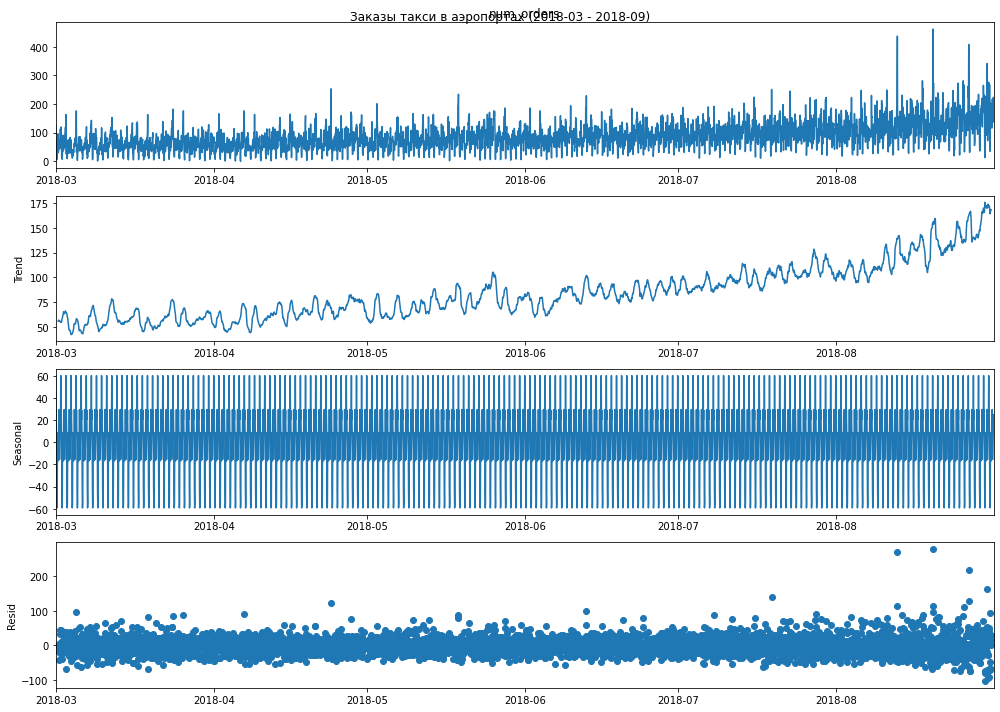

In [4]:
# Рассмотрим на графике основные параметры нашего временного ряда
decomposed = seasonal_decompose(df['num_orders'])
plt.rcParams.update({'figure.figsize': (14,10)})
decomposed.plot().suptitle('Заказы такси в аэропортах (2018-03 - 2018-09)')
plt.show()

#### Вывод
* Мы проверили временной ряд на монотонность, произвели ресемплирование в 1 час в соответствиями с условиями. Как видно из графика наш ряд достаточно стационарный для дальнейшей работы.

# 2. Анализ<a id='2-bullet'></a>

In [5]:
# Выберем период - один месяц чтобы подробнее рассмотреть колебания заказов такси
df_month = df.loc['2018-04']
decomposed = seasonal_decompose(df_month['num_orders'])

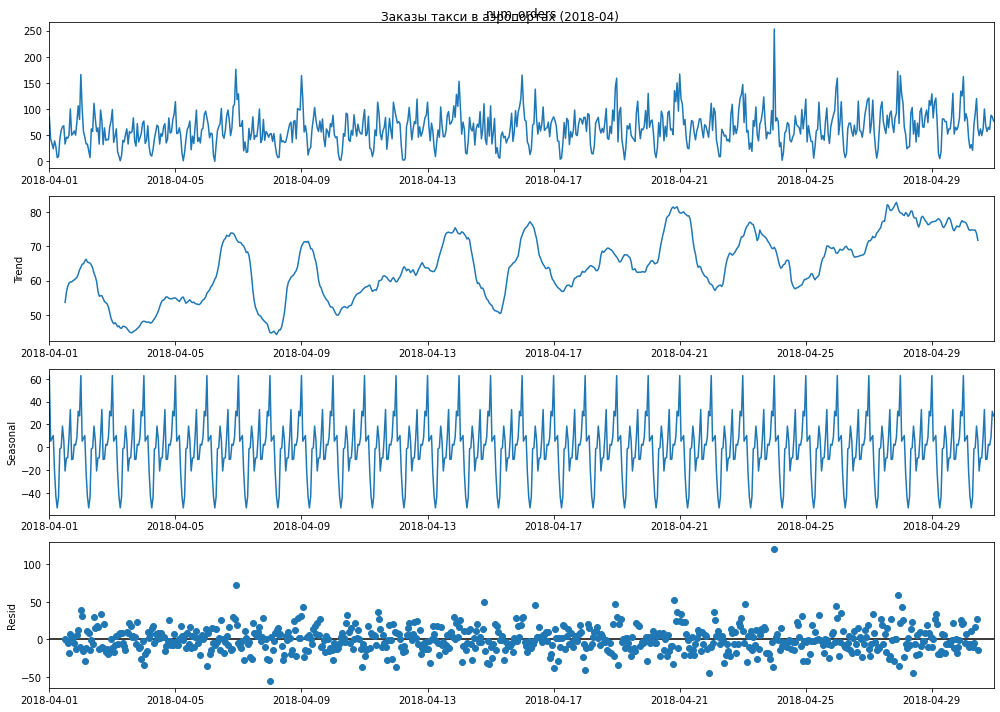

In [6]:
# Разложим временной ряд на тренд, сезонность и остаток месячного периода, чтобы подробнее рассмотреть движение
plt.rcParams.update({'figure.figsize': (14,10)})
decomposed.plot().suptitle('Заказы такси в аэропортах (2018-04)')
plt.show()

#### Вывод
Разложив временной ряд на тренд, сезонность и остаток (шум), можно сказать следующее:
1. На графике Trend видны "движения" - с недельным периодом;
2. На графике Seasonal видим суточные движения которые представляют из себя стационарный стохастический процесс т.е. каждые сутки определенная часть заказов такси повторяется;
3. На графике Resid мы видим случайную не прогнозируемую состовляющую заказов такси - так называемый шум.

# 3. Обучение<a id='3-bullet'></a>

In [7]:
# Функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['Hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return data

In [8]:
# Создадим признаки для горизонта прогнозирования в 7 дней т.е. неделю, удалим строки с образовавшимися пропусками
df_taxi = make_features(df, 168, 168).dropna()

In [9]:
# Разобъем наши данные на тренировочную, валидационную и тестовую выборки:  70/20/10%
features = df_taxi.drop(['num_orders'], axis = 1)
target = df_taxi['num_orders']

# Разделим данные на обучающую и тестовую, валидационную выборки
features_train_valid, features_test, target_train_valid, target_test = (
                train_test_split(features, target, test_size=0.1, shuffle=False))

# Разделим выборку на тестовую и валидационную, соответственно 30% и 10% от основной.
features_train, features_valid, target_train, target_valid = (
                train_test_split(features_train_valid, target_train_valid, test_size=0.225, shuffle=False))

print('Размер исходной выборки:',df_taxi.shape)
print('Размер тренировочной выборки:',features_train.shape)
print('Размер валидационной выборки:',features_valid.shape)
print('Размер валидационной выборки:',features_test.shape)

Размер исходной выборки: (4248, 174)
Размер тренировочной выборки: (2962, 173)
Размер валидационной выборки: (861, 173)
Размер валидационной выборки: (425, 173)


#### Обучим модель Линейной регрессии

In [10]:
start = time.time()
LR = LinearRegression()
LR.fit(features_train, target_train)
predictions_valid = LR.predict(features_valid)
print("RMSE на валидационной выборке: ", round(mean_squared_error(target_valid, predictions_valid) ** 0.5,1))
end = time.time()
LinearRegression_time1 = round(end - start, 1)

RMSE на валидационной выборке:  27.2


#### Найдем гиперпараметры и обучим модель Решающего дерева

In [11]:
start = time.time()
best_model = None
best_result = 48
best_depth = 0
for depth in range(1, 20):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    if result < best_result:
        tree_model = model
        best_result = result
        best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", round(best_result,1), 
      "Количество деревьев:", best_depth)
end = time.time()
TreeRegressor_time1 = round(end - start, 1)

RMSE наилучшей модели на валидационной выборке: 31.5 Количество деревьев: 5


#### Найдем гиперпараметры и обучим модель Cлучайного леса

In [12]:
start = time.time()
best_model = None
best_result = 48
best_est = 0
best_depth = 0
for est in range(10, 30, 5):
    for depth in range (2, 10, 2):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train) # обучите модель на тренировочной выборке
        predictions_valid = model.predict(features_valid) # получите предсказания модели на валидационной выборке
        result = mean_squared_error(target_valid, predictions_valid) ** 0.5
        if result < best_result:
            forest_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", round(best_result, 1), 
      "Количество деревьев:", best_est, 
      "Максимальная глубина:", depth)
end = time.time()
RandomForest_time1 = round(end - start, 1)

RMSE наилучшей модели на валидационной выборке: 29.5 Количество деревьев: 25 Максимальная глубина: 8


#### Найдем гиперпараметры и обучим модель LGBM ансамбля

In [13]:
start = time.time()
best_model = None
best_result = 48
best_est = 0
best_depth = 0
best_leaves = 0
for est in range(10, 150, 10):
    for depth in range (2, 10, 2):
        for leaves in range (3, 5, 1):
            model = LGBMRegressor(random_state=12345, n_estimators=est, max_depth=depth, 
                                  num_leaves=leaves, cat_column={0, 1, 2, 3, 4})
            model.fit(features_train, target_train) 
            predictions_valid = model.predict(features_valid) 
            result = mean_squared_error(target_valid, predictions_valid) ** 0.5
            if result < best_result:
                LGBM_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_leaves = leaves

print("RMSE наилучшей модели на валидационной выборке:", round(best_result,1), 
      "Количество деревьев:", best_est, 
      "Максимальная глубина:", depth,
      "Количество листов:", leaves)
end = time.time()
LGBMRegressor_time1 = round(end - start, 1)

RMSE наилучшей модели на валидационной выборке: 27.6 Количество деревьев: 140 Максимальная глубина: 8 Количество листов: 4


#### Вывод
1. Так как временной ряд нельзя нарушать, разделение выборки на признаки произвели с параметром shuffle=False;
2. Мы обучили 4 модели на тестовых данных и нашли лучшие гиперпараметры на валидационной выборке, кроме линейной регрессии.

# 4. Тестирование<a id='4-bullet'></a>

In [14]:
# Линейная регрессия
start = time.time()
predictions_LR = LR.predict(features_test)
RMSE_linear = round(mean_squared_error(target_test, predictions_LR) ** 0.5, 1)
print("RMSE Линейной регрессии на тестовой выборке: ", RMSE_linear)
end = time.time()
LinearRegression_time3 = round(end - start, 1)

RMSE Линейной регрессии на тестовой выборке:  38.2


In [15]:
# Модель Решающего дерева
start = time.time()
tree_model = DecisionTreeRegressor(random_state=12345, max_depth=5)
tree_model.fit(features_train_valid, target_train_valid)
end = time.time()
TreeRegressor_time2 = round(end - start, 1)

start = time.time()
predictions_tree = tree_model.predict(features_test)
RMSE_Tree = round(mean_squared_error(target_test, predictions_tree) ** 0.5, 1)
print("RMSE Решающего дерева на тестовой выборке: ", RMSE_Tree)
end = time.time()
TreeRegressor_time3 = round(end - start, 1)

RMSE Решающего дерева на тестовой выборке:  52.1


In [16]:
# Модель Cлучайного леса
start = time.time()
forest_model = RandomForestRegressor(random_state=12345, n_estimators=25, max_depth=8)
forest_model.fit(features_train_valid, target_train_valid)
end = time.time()
RandomForest_time2 = round(end - start, 1)

start = time.time()
predictions_forest = forest_model.predict(features_test)
RMSE_RandomForest = round(mean_squared_error(target_test, predictions_forest) ** 0.5, 1)
print("RMSE Cлучайного леса на тестовой выборке: ", RMSE_RandomForest)
end = time.time()
RandomForest_time3 = round(end - start, 1)

RMSE Cлучайного леса на тестовой выборке:  40.8


In [17]:
# Модель LGBM ансамбля
start = time.time()
LGBM_model = LGBMRegressor(random_state=12345, n_estimators=140, max_depth=8, num_leaves=4, cat_column={0, 1, 2, 3, 4})
LGBM_model.fit(features_train_valid, target_train_valid)
end = time.time()
LGBMRegressor_time2 = round(end - start, 1)

start = time.time()
predictions_LGBM = LGBM_model.predict(features_test)
RMSE_LGBM = round(mean_squared_error(target_test, predictions_LGBM) ** 0.5, 1)
print("RMSE LGBM ансамбля на тестовой выборке: ", RMSE_LGBM)
end = time.time()
LGBMRegressor_time3 = round(end - start, 1)

RMSE LGBM ансамбля на тестовой выборке:  38.4


In [18]:
data = {'Алгоритм':['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LGBMRegressor'],
        'Время подбора гиперпараметров' : [LinearRegression_time1, TreeRegressor_time1, RandomForest_time1, LGBMRegressor_time1],
        'Время обучения модели':[0, TreeRegressor_time2, RandomForest_time2, LGBMRegressor_time2],
        'Время предсказания': [LinearRegression_time3, TreeRegressor_time3, RandomForest_time3, LGBMRegressor_time3],
        'Качество модели (RMSE)':[RMSE_linear, RMSE_Tree, RMSE_RandomForest, RMSE_LGBM]}
     
models = pd.DataFrame(data=data)
models = models.set_index('Алгоритм')
models['Время обучения и предсказания'] = models['Время обучения модели'] + models['Время предсказания']
models['Общее время'] = models['Время подбора гиперпараметров'] + models['Время обучения модели'] + models['Время предсказания']

# Вывод <a id='5-bullet'></a>
* Заново обучили модели с найденными ранее гиперпараметрами на объединенной тренировочной и валидационной выборке т.е. почти на 90% данных исключая 168 часов данных которые мы удалили в виду образовавшихся пропусков при создании дополнительных признаков.
* Линейная регрессия показала себя лучше всего в этом соревновании как в скорости работы так и в качестве прогноза.

In [19]:
display(models)   

,Время подбора гиперпараметров,Время обучения модели,Время предсказания,Качество модели (RMSE),Время обучения и предсказания,Общее время
Алгоритм,,,,,,
LinearRegression,0.0,0.0,0.0,38.2,0.0,0.0
DecisionTreeRegressor,3.9,0.2,0.0,52.1,0.2,4.1
RandomForestRegressor,19.7,3.7,0.0,40.8,3.7,23.4
LGBMRegressor,10.9,0.1,0.0,38.4,0.1,11.0
